In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

datafiles = ["gor.h5", "Kolmogorov.h5", "aida.h5", "odinmaniac-ThinkPad-T14s-Gen-1.h5"]

experiments = pd.concat([pd.read_hdf(datafile) for datafile in datafiles], axis=0)
# experiments["seed"].fillna(-100, inplace=True)
experiments.dropna(inplace=True)
experiments = experiments[experiments.valid_columns & experiments.valid_time_final]


In [2]:
nominals = experiments[experiments.controller == "calf_ex_post"]
nominals = nominals[nominals.finished_episodes == 1]

safe_onlys = []
for o in nominals.overrides:
    parsed = json.loads(o)
    if parsed.get("+controller.safe_only") is not None:
        safe_onlys.append(parsed.get("+controller.safe_only") == "True")
    else:
        safe_onlys.append(False)

nominals = nominals.loc[safe_onlys]

nominals = nominals.groupby(["controller", "system", "seed"])[
    "best_total_objective"
].max()
nominals = nominals[nominals < 10e4]
nominals = nominals.loc["calf_ex_post"]
nominals = nominals.droplevel("seed", axis=0)

In [3]:
nominals.groupby("system").median()

system
2tank           1342.094721
3wrobot         3736.840063
3wrobot_ni       619.252227
cartpole        5372.673276
inv_pendulum     306.854370
kin_point       3853.013371
lunar_lander      82.168266
Name: best_total_objective, dtype: float64

In [4]:
[
    "mpc",
    "rql",
    "rpo",
    "calf_ex_post",
    "calf_predictive",
    "dqn",
    "ddqn",
    "ddpg",
    "acpg",
    "sarsa",
    "nominal",
]



['mpc',
 'rql',
 'rpo',
 'calf_ex_post',
 'calf_predictive',
 'dqn',
 'ddqn',
 'ddpg',
 'acpg',
 'sarsa',
 'nominal']

In [51]:
basic = [
    "rql",
    "dqn",
    "ddqn",
    "ddpg",
    "acpg",
    "sarsa",
    "rpo",
    "calf_ex_post",
    "calf_predictive",
]
finished_episodes_thr = 20


def process_controllers(controllers, experiments, finished_episodes_thr=20):
    aggregated = {}
    for controller in controllers:
        controller_experiments = experiments[
            (experiments.controller == controller)
            & (experiments.finished_episodes == finished_episodes_thr)
        ]

        ids = (
            controller_experiments.groupby(["system", "seed"])["best_total_objective"]
            .idxmax()
            .values
        )
        controller_experiments = controller_experiments.loc[ids].set_index("system")
        controller_systems = list(controller_experiments.index.unique())

        item = {}
        for s in controller_systems:
            if isinstance(controller_experiments.loc[s].total_objectives, pd.DataFrame):
                item[s] = controller_experiments.loc[s].total_objectives.set_index(
                    "episode"
                )
            else:
                item[s] = pd.concat(
                    [
                        v.set_index("episode")
                        for v in controller_experiments.loc[s].total_objectives.tolist()
                    ],
                    axis=1,
                )
        aggregated[controller] = item

    return aggregated


aggregated = process_controllers(
    [
        "rql",
        "dqn",
        "ddqn",
        "ddpg",
        "acpg",
        "sarsa",
        "rpo",
        "calf_ex_post",
        "calf_predictive",
    ],
    experiments,
    20,
)

aggregated["calf"] = aggregated["calf_ex_post"] | aggregated["calf_predictive"]
aggregated["nominal"] = nominals

In [6]:
mpc_experiments = experiments[experiments.controller == "mpc"]
mpc_experiments["horizon"] = [
    json.loads(o).get("controller.actor.predictor.prediction_horizon")
    for o in mpc_experiments.overrides
]
mpc_experiments.dropna(inplace=True)
mpc_experiments.controller = (
    mpc_experiments.controller + "N" + mpc_experiments["horizon"]
)

aggregated.update(
    process_controllers(
        mpc_experiments.controller.unique().tolist(), mpc_experiments, 1
    )
)

/tmp/ipykernel_1464316/2977136432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpc_experiments["horizon"] = [
/tmp/ipykernel_1464316/2977136432.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpc_experiments.dropna(inplace=True)
/tmp/ipykernel_1464316/2977136432.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [7]:
aggregated.keys()

dict_keys(['rql', 'dqn', 'ddqn', 'ddpg', 'acpg', 'sarsa', 'rpo', 'calf_ex_post', 'calf_predictive', 'calf', 'nominal', 'mpcN2', 'mpcN5', 'mpcN8'])

In [8]:
aggregated["calf"]["2tank"]

,objective,objective,objective,objective,objective,objective,objective,objective,objective,objective,objective,objective,objective,objective
episode,,,,,,,,,,,,,,
1,1748.269895,1287.816178,1618.149371,1906.392769,787.265247,1632.187543,1099.345362,1611.176527,939.425248,1314.704388,825.008031,1780.870739,765.002929,1230.367525
2,1792.351303,1329.695381,1670.581444,1907.771310,787.993983,1633.164580,1094.304980,1612.426818,940.953236,1284.498088,826.034645,1942.434012,765.748293,1215.803228
3,1957.675794,1318.814366,1678.121980,1907.771311,787.993983,1633.164580,1094.304973,1612.426819,940.953236,1284.498085,826.034645,1782.062233,765.748292,1215.803203
4,1743.130883,1339.952369,1792.951897,1907.771311,787.993983,1633.164580,1094.304973,1612.426819,940.953236,1284.498085,826.034645,1954.833790,765.748292,1215.803203
5,1792.351303,1329.698088,1604.928657,1907.771311,787.993983,1633.164580,1094.304973,1612.426819,940.953236,1284.498085,826.034645,1782.062232,765.748292,1215.803203
6,1957.675794,1318.814366,1662.131673,1907.771311,787.993983,1633.164580,1094.304973,1612.426819,940.953236,1284.498085,826.034645,1954.833790,765.748292,1215.803203
7,1743.130883,1339.952369,1660.176896,1907.771311,787.993983,1633.164580,1094.304973,1612.426819,940.953236,1284.498085,826.034645,1782.062232,765.748292,1215.803203
8,1792.351303,1329.698088,1826.129980,1907.771311,787.993983,1633.164580,1094.304973,1612.426819,940.953236,1284.498085,826.034645,1954.833790,765.748292,1215.803203
9,1957.675794,1318.814366,1596.865471,1907.771311,787.993983,1633.164580,1094.304973,1612.426819,940.953236,1284.498085,826.034645,1782.062232,765.748292,1215.803203


In [ ]:
aggregated["ddpg"]

In [ ]:
values = np.array([3,4,-1,-2,5,60])
values[np.argmin(values)]

rql      1369.205534
dqn      1209.208852
ddqn     2162.692586
ddpg     1235.493099
acpg     1191.628891
sarsa    1205.832194
rpo      1112.556288
calf     1301.260283
dtype: float64


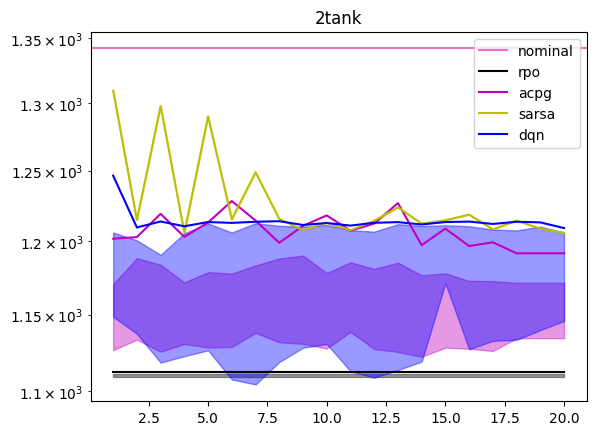

rql      2.012066e+05
dqn      1.347298e+05
ddqn     1.553634e+06
ddpg     7.479288e+06
acpg     3.563361e+06
sarsa    6.733045e+05
rpo      2.473682e+04
calf     6.067620e+03
dtype: float64


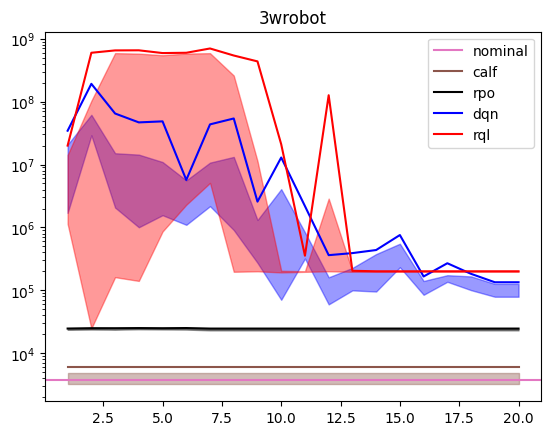

rql       490.429584
dqn      1937.471945
ddqn     4524.863533
ddpg     1644.920206
acpg     2265.564260
sarsa    2189.334468
rpo       587.492485
calf      149.202931
dtype: float64


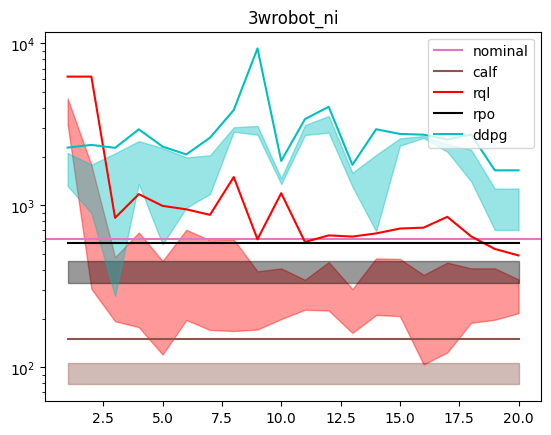

rql        2110.136879
dqn        1918.300530
ddqn     274913.888563
ddpg       2009.396996
acpg       1992.043548
sarsa      2118.358004
rpo        1962.375487
calf        306.776786
dtype: float64


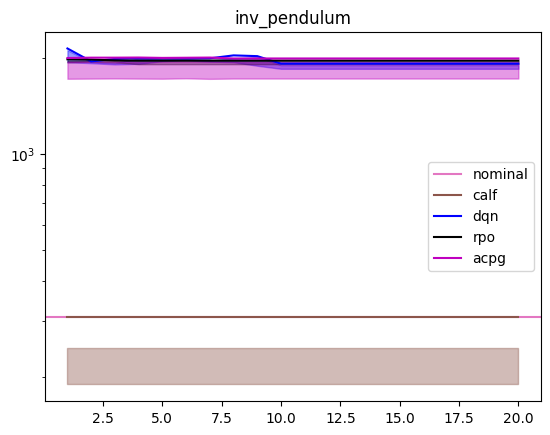

rql      9.002050e+03
dqn      3.178602e+03
ddqn     3.202861e+06
ddpg     9.071923e+06
acpg     8.160027e+06
sarsa    1.049856e+07
rpo      3.624543e+04
calf     2.976726e+07
dtype: float64


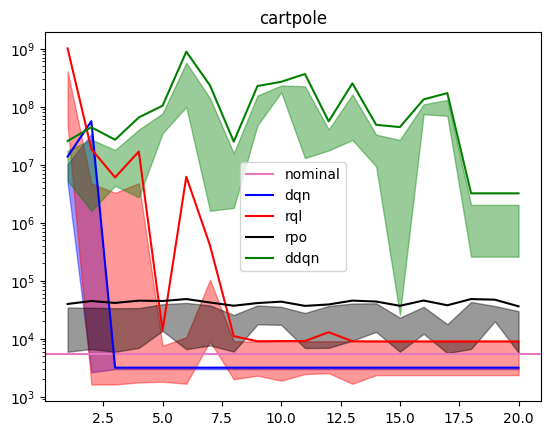

rql       1353.082774
dqn        298.193124
ddqn     38790.702924
ddpg       172.816454
acpg       172.701410
sarsa     2947.696371
rpo        176.237392
calf        70.991659
dtype: float64


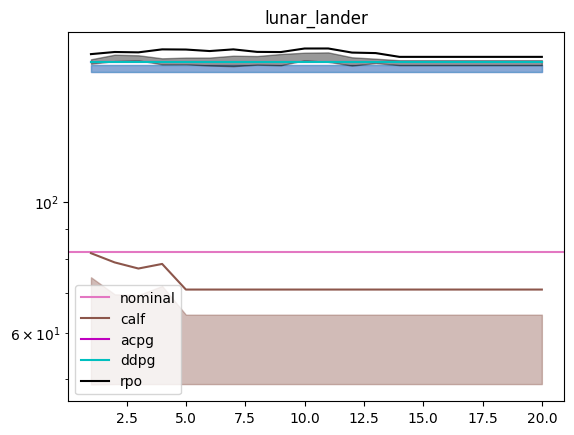

rql       1602.006561
dqn      13896.270155
ddqn     17471.560075
ddpg      1359.788349
acpg     33645.408509
sarsa     7178.335501
rpo       1554.370875
calf      1316.168419
dtype: float64


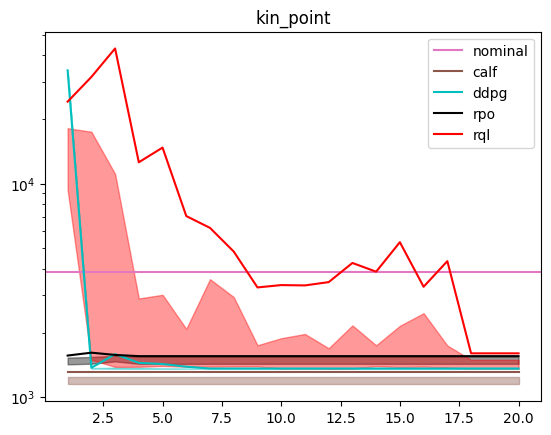

In [52]:
aggregated.keys()
systems = [
    "2tank",
    "3wrobot",
    "3wrobot_ni",
    "inv_pendulum",
    "cartpole",
    "lunar_lander",
    "kin_point",
]
r = 0.2
colors = {
    "rql": "r",
    "dqn": "b",
    "ddqn": "g",
    "ddpg": "c",
    "acpg": "m",
    "sarsa": "y",
    "rpo": "k",
    "calf": "tab:brown",
    "nominal": "tab:pink",
    # "mpcN2": "tab:cyan",
    # "mpcN5": "aquamarine",
    # "mpcN8": "mediumseagreen",
}
top_n = 4

for s in systems:
    plt.title(s)
    plt.axhline(
        aggregated["nominal"].loc[s].median(), c=colors["nominal"], label="nominal"
    )

    mins = pd.Series(
        {
            c: aggregated[c][s].quantile(q=0.5, axis=1).min()
            for c in colors.keys()
            if c not in ["nominal", "calf_ex_post", "calf_predictive"]
        }
    )
    best_perfomance = mins.sort_values(ascending=True)[:top_n]
    print(mins)
    
    for c in best_perfomance.index:
        if c != "nominal":
            if aggregated[c].get(s) is not None:
                
                values = aggregated[c][s].quantile(q=0.5, axis=1)
                argmin = np.argmin(values)
                values.iloc[argmin:] = min(values)
                lower_bounds = aggregated[c][s].min(axis=1) #quantile(q=0.5 + r, axis=1)
                upper_bounds = aggregated[c][s].quantile(q=0.5 - r, axis=1)
                a, b = lower_bounds.iloc[argmin], upper_bounds.iloc[argmin]
                lower_bounds.iloc[argmin:] = a
                upper_bounds.iloc[argmin:] = b
                    
                plt.plot(values, c=colors[c], label=c)
                plt.yscale("log")
                plt.fill_between(
                    values.index,
                    lower_bounds.values,
                    upper_bounds.values,
                    alpha=0.4,
                    color=colors[c],
                )
                plt.legend()

    plt.show()

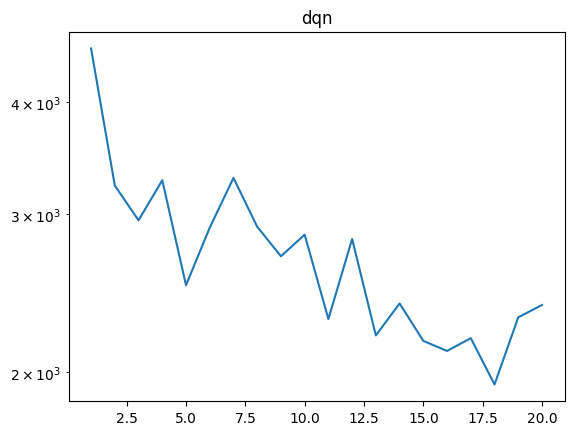

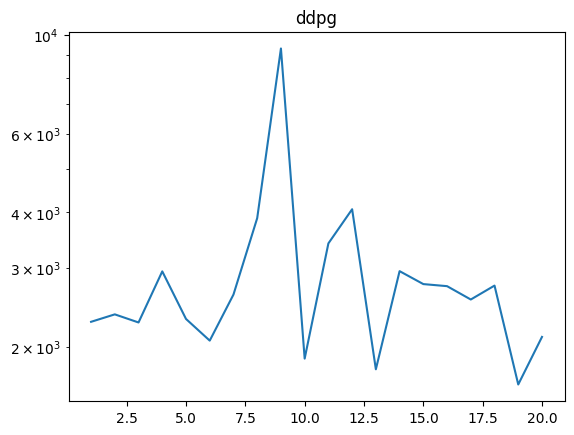

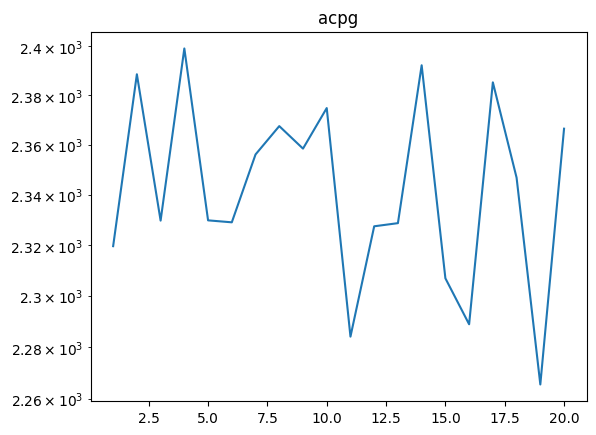

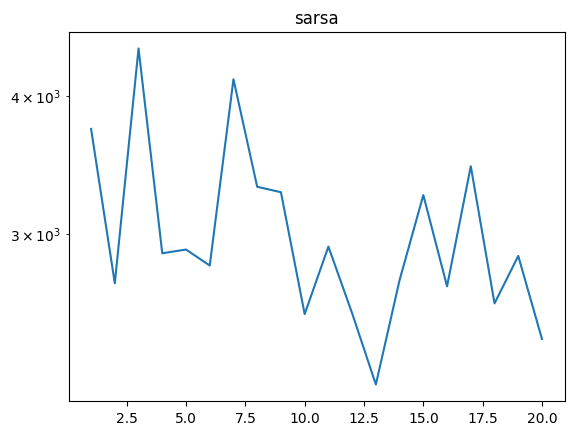

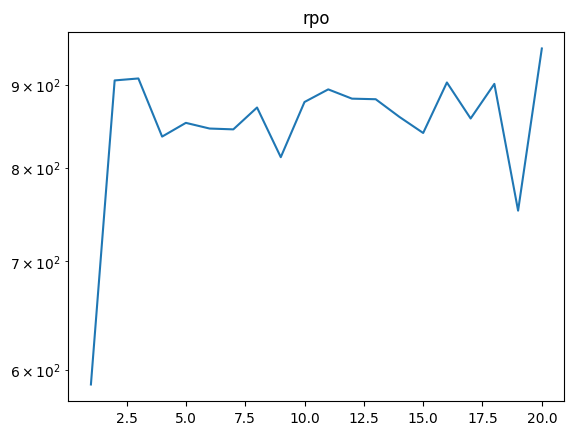

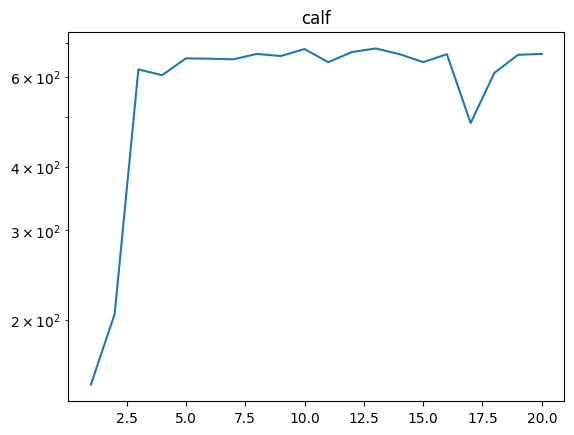

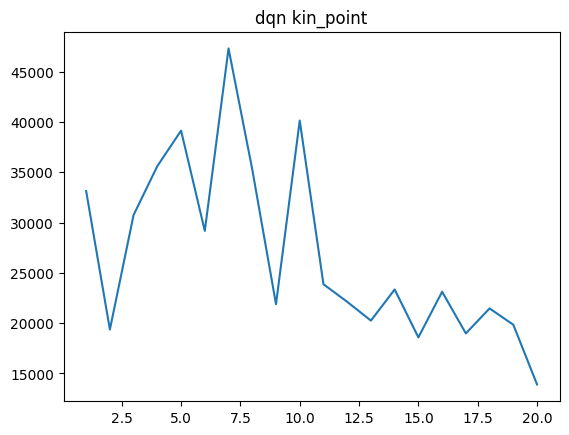

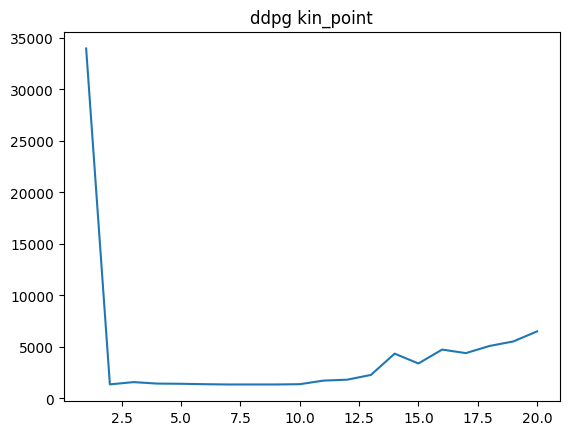

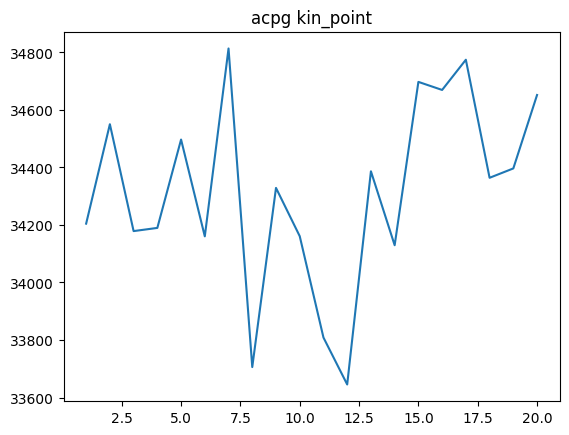

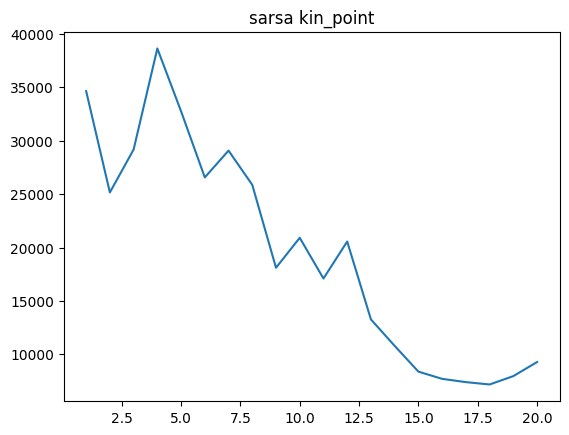

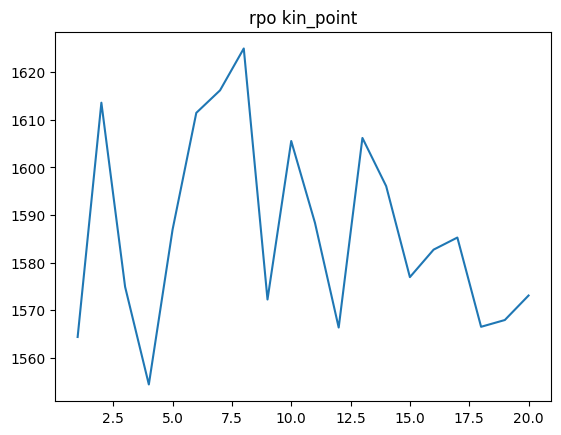

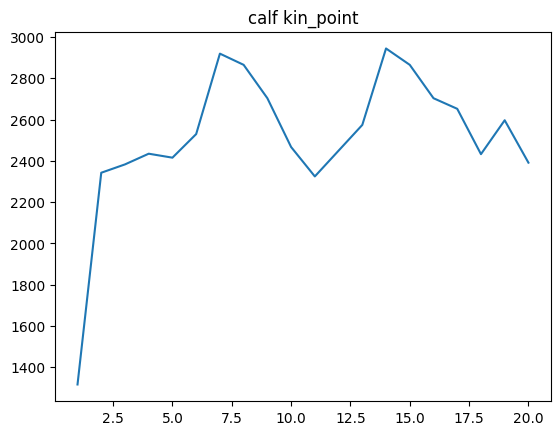

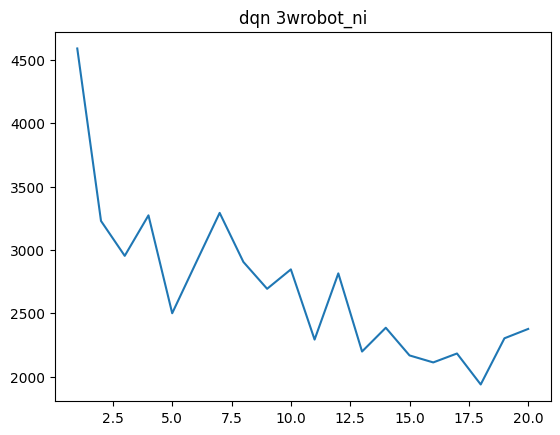

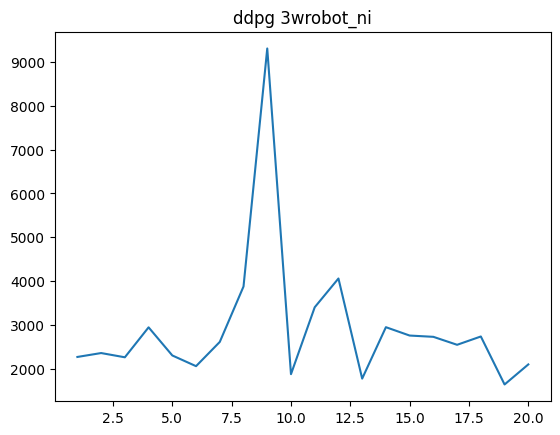

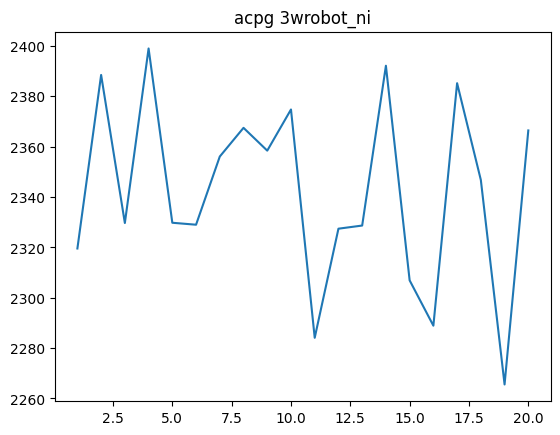

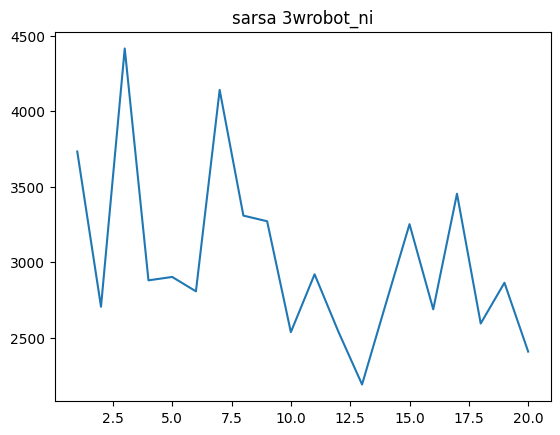

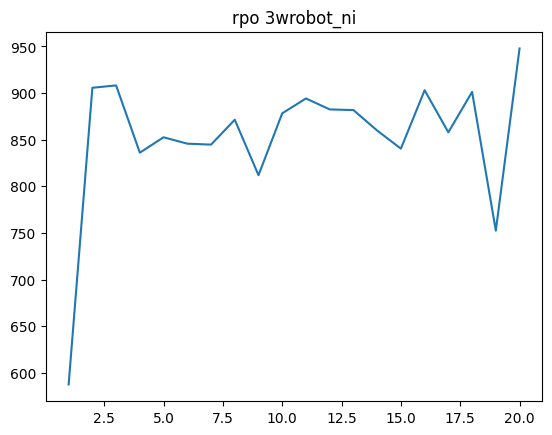

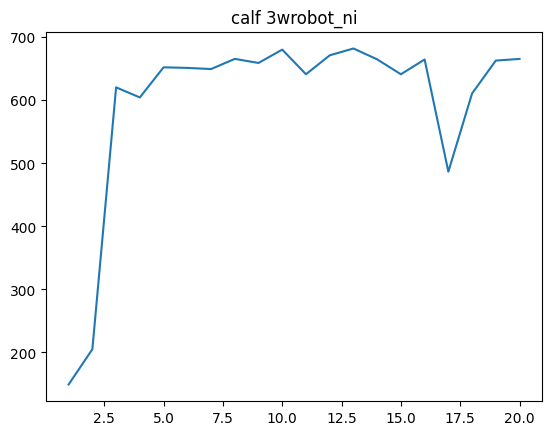

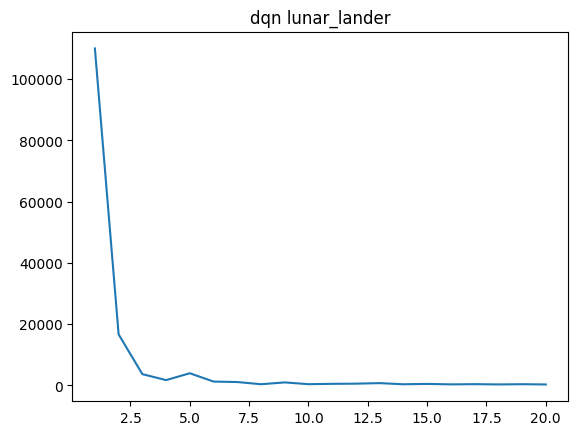

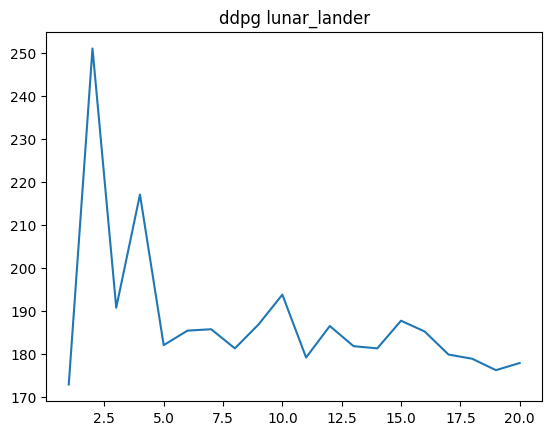

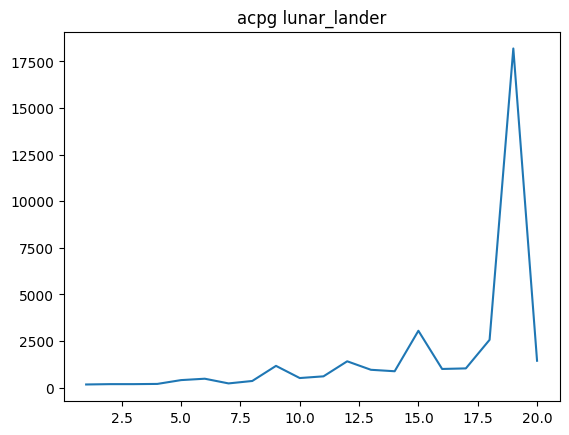

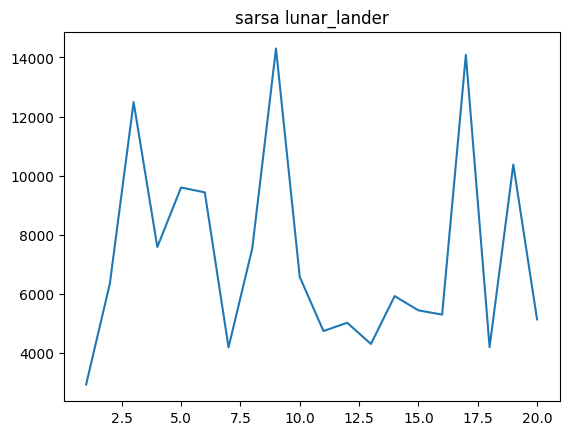

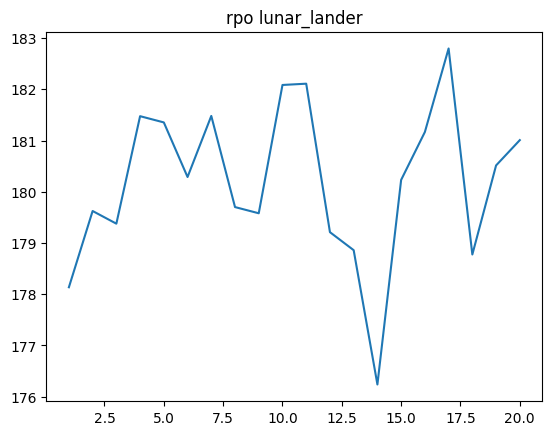

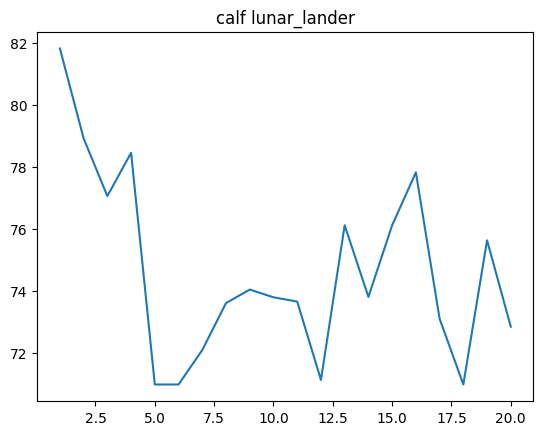

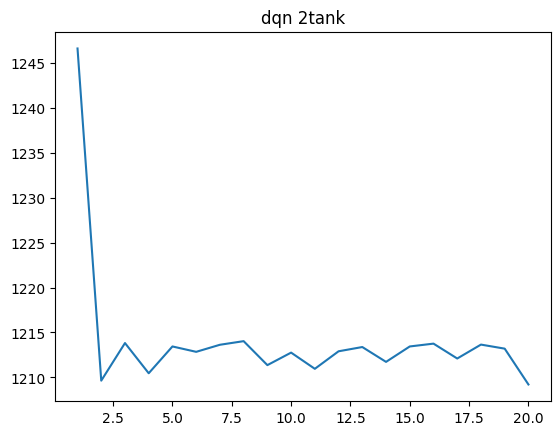

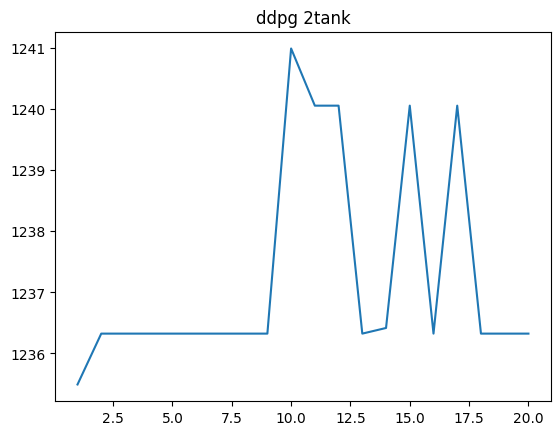

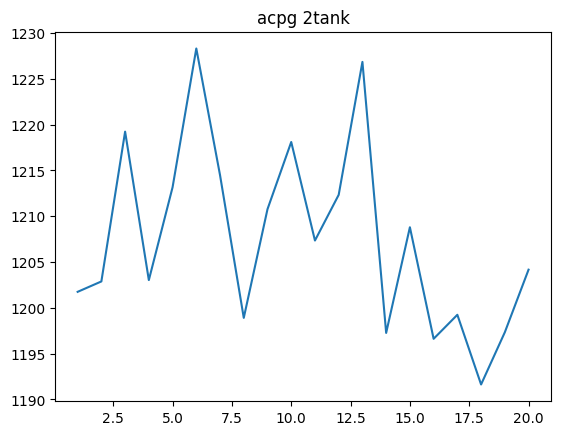

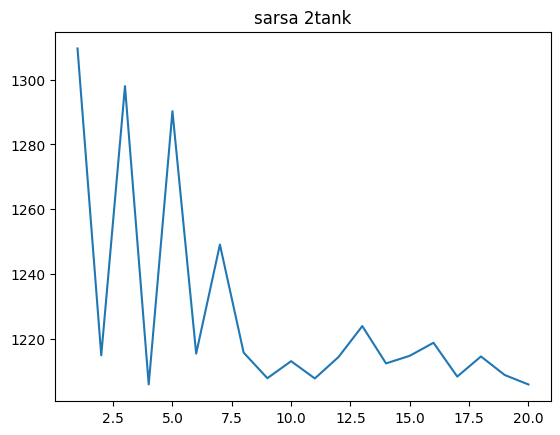

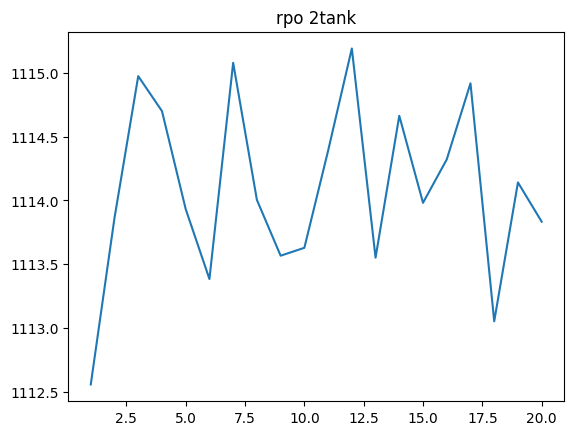

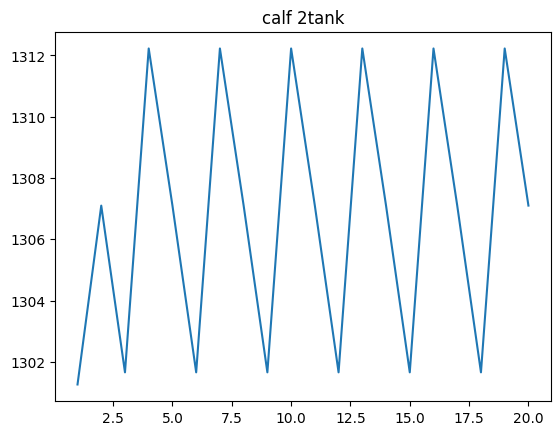

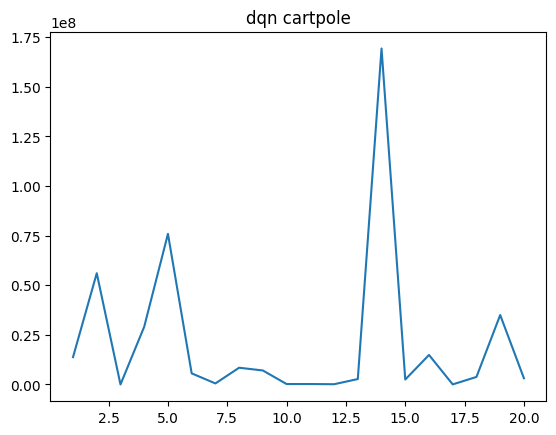

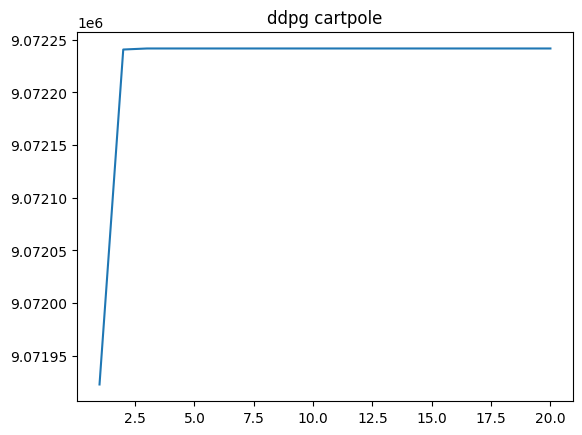

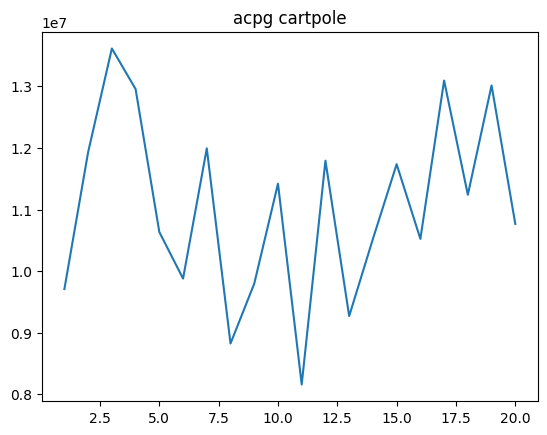

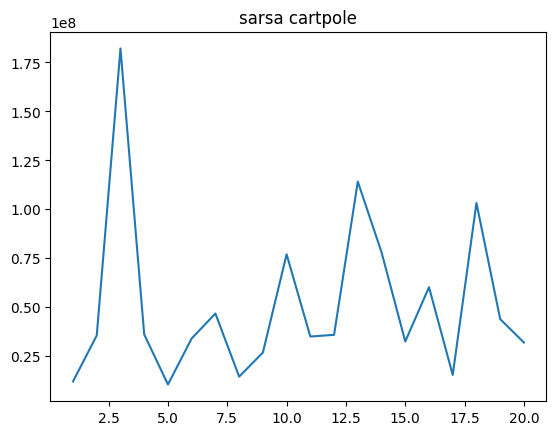

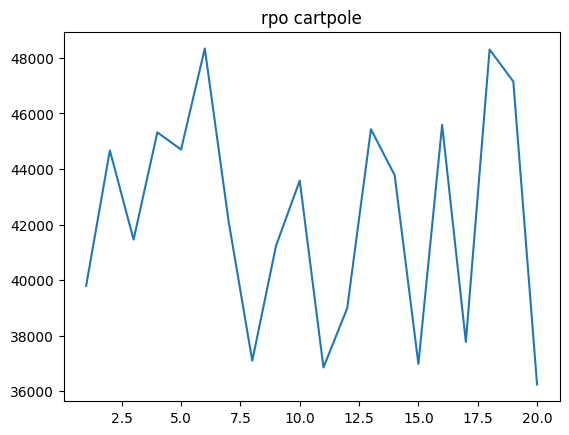

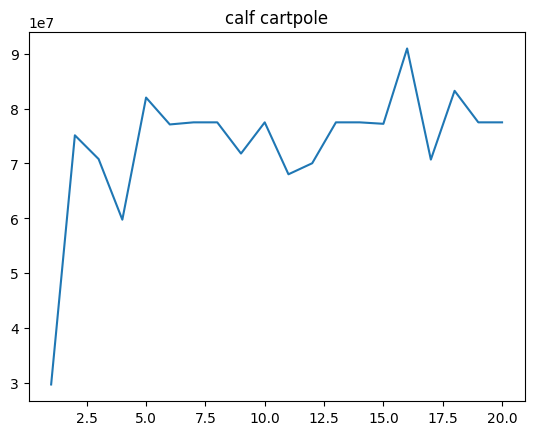

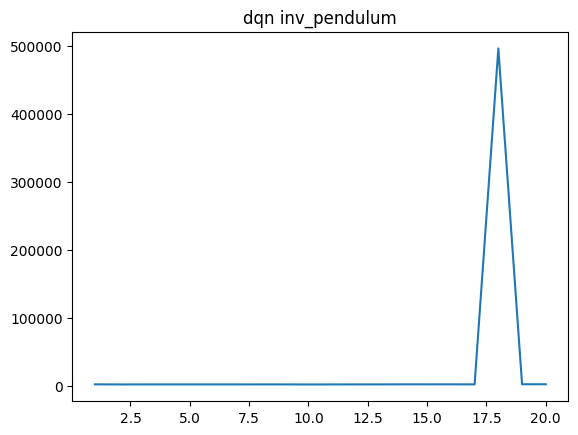

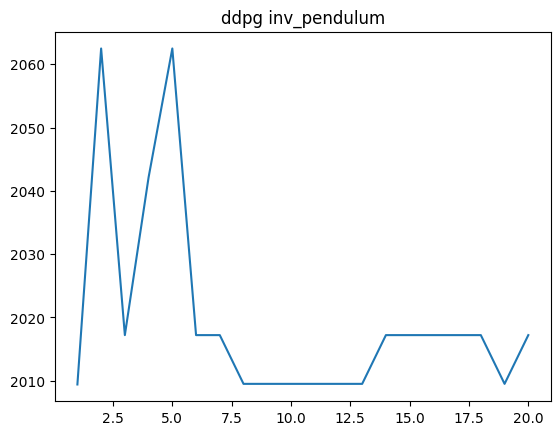

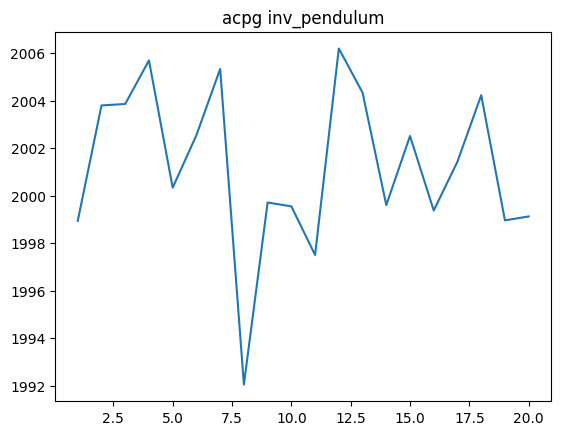

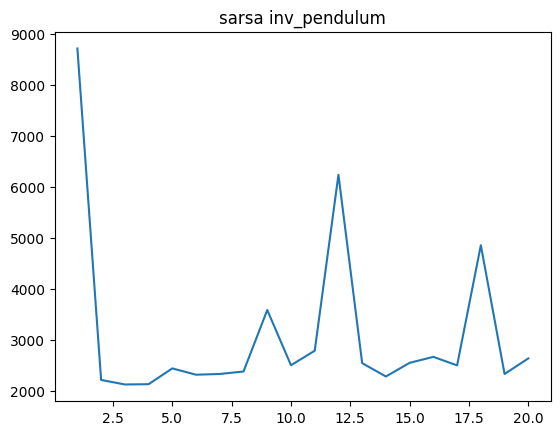

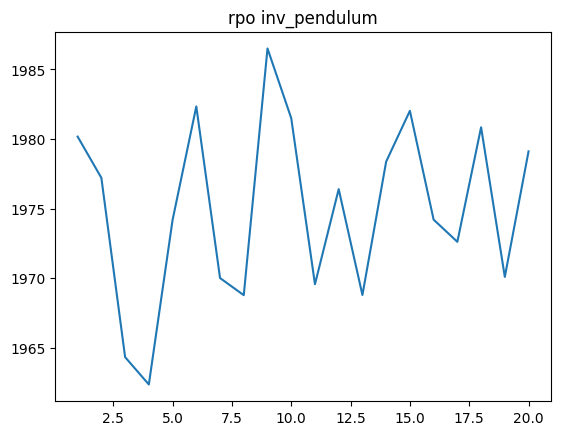

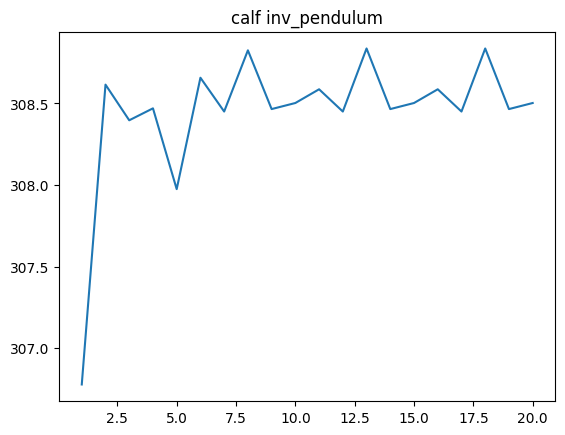

In [97]:
system_namings = {    
    "kin_point" : "Kinematic Point",
    "3wrobot_ni" : "3-wheeled Robot",
    "lunar_lander" : "Lunar Lander",
    "2tank" : "2-tank system",
    "cartpole" : "Cartpole",
    "inv_pendulum" : "Inverted Pendulum"
}

system = "3wrobot_ni"

for system in system_namings:
    for c in aggregated:
        if c in ["calf", "acpg", "ddpg", "dqn", "sarsa", "rpo"]:
            if aggregated[c].get(system) is not None:
                plt.title(c + " " + system)
                plt.plot(aggregated[c][system].median(axis=1))
                # plt.yscale("log")
                plt.show()
                

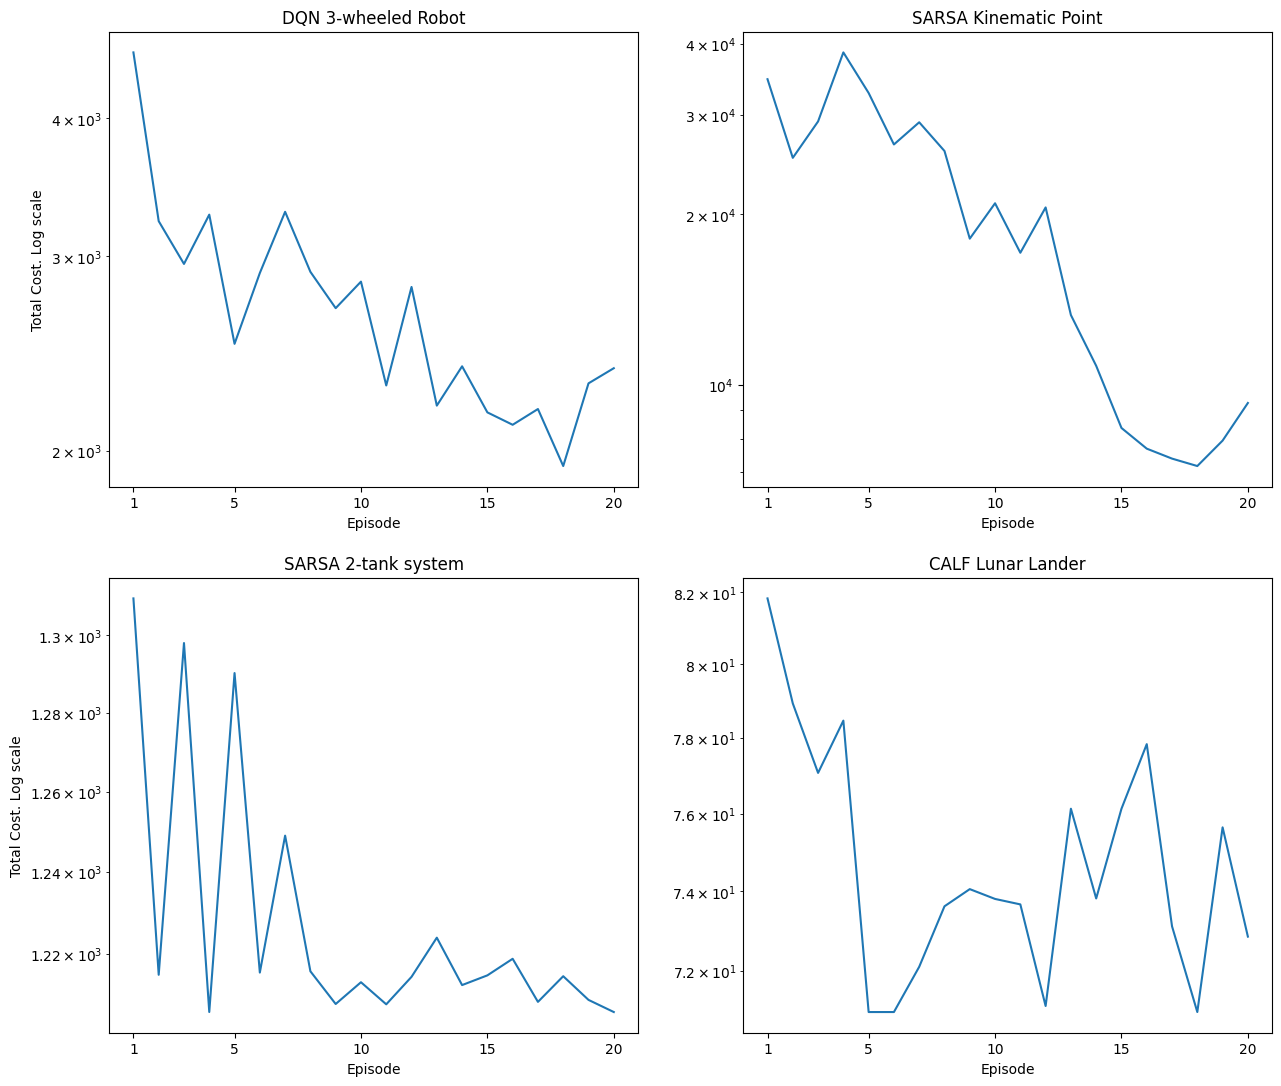

In [125]:

namings = {
    "ddpg" : "DDPG",
    "acpg" : "SDPG",
    "sarsa" : "SARSA",
    "rpo" : "RPO",
    "calf" : "CALF",
    "dqn" : "DQN",
    "nominal" : "CALF Stabilizing Policy",
}

system_namings = {    
    "kin_point" : "Kinematic Point",
    "3wrobot_ni" : "3-wheeled Robot",
    "lunar_lander" : "Lunar Lander",
    "2tank" : "2-tank system",
    "cartpole" : "Cartpole",
    "inv_pendulum" : "Inverted Pendulum"
}

mapping = {
    "kin_point" : ["sarsa"],
    "3wrobot_ni" : ["dqn"], 
    "lunar_lander" : ["calf"],
    "2tank" : ["sarsa"]
}

plt.figure(figsize=(15, 13))

system = "3wrobot_ni"
plt.subplot(2, 2, 1)
plt.title(namings[mapping[system][0]] + " " +  system_namings[system])
for c in mapping[system]:
    aggregated[c][system].median(axis=1).plot(label=namings[c])
    lower_bounds = aggregated[c][system].quantile(q=0.5 + r, axis=1) #quantile(q=0.5 + r, axis=1)
    upper_bounds = aggregated[c][system].quantile(q=0.5 - r, axis=1)
    
plt.xticks([1, 5, 10, 15, 20])
plt.yscale("log")
plt.xlabel("Episode")
plt.ylabel("Total Cost. Log scale")

system = "kin_point"

plt.subplot(2, 2, 2)
plt.title(namings[mapping[system][0]] + " " +  system_namings[system])
for c in mapping[system]:
    values = aggregated[c][system].median(axis=1).values
    lower_bounds = aggregated[c][system].quantile(q=0.5 + r, axis=1) #quantile(q=0.5 + r, axis=1)
    upper_bounds = aggregated[c][system].quantile(q=0.5 - r, axis=1)
    plt.fill_between(
                    values.index,
                    lower_bounds.values,
                    upper_bounds.values,
                    alpha=0.4,
                    color=colors[c],
                )
plt.xticks([1, 5, 10, 15, 20])
plt.yscale("log")
plt.xlabel("Episode")

system = "2tank"

plt.subplot(2, 2, 3)
plt.title(namings[mapping[system][0]] + " " + system_namings[system])
for c in mapping[system]:
    aggregated[c][system].median(axis=1).plot(label=namings[c])
    lower_bounds = aggregated[c][system].quantile(q=0.5 + r, axis=1) #quantile(q=0.5 + r, axis=1)
    upper_bounds = aggregated[c][system].quantile(q=0.5 - r, axis=1)
    
plt.xticks([1, 5, 10, 15, 20])
plt.yscale("log")
plt.xlabel("Episode")
plt.ylabel("Total Cost. Log scale")

system = "lunar_lander"

plt.subplot(2, 2, 4)
plt.title(namings[mapping[system][0]] + " " + system_namings[system])
for c in mapping[system]:
    aggregated[c][system].median(axis=1).plot(label=namings[c])
    lower_bounds = aggregated[c][system].quantile(q=0.5 + r, axis=1) #quantile(q=0.5 + r, axis=1)
    upper_bounds = aggregated[c][system].quantile(q=0.5 - r, axis=1)
    
plt.xticks([1, 5, 10, 15, 20])
plt.yscale("log")
plt.xlabel("Episode")

plt.show()

# Kinematic Point

## Calf vs. MPC

In [ ]:
system = "kin_point"
r = 0.2

calf_values = aggregated["calf"][system].median(axis=1)
lower_bounds = aggregated["calf"][system].quantile(q=0.5 - r, axis=1)
upper_bounds = aggregated["calf"][system].quantile(q=0.5 + r, axis=1)
plt.fill_between(
    values.index,
    lower_bounds.values,
    upper_bounds.values,
    alpha=0.4,
    color="purple",
)
calf_values.plot(c="purple", label="CALF")
plt.axhline(aggregated["nominal"].loc[system].median(), label="nominal", ls="--", c="r")
plt.axhline(
    aggregated["mpcN2"][system].median(axis=1).iloc[0], label="MPC", ls="--", c="g"
)
plt.legend()
plt.xticks([1, 5, 10, 15, 20])
plt.xlabel("Episode")
plt.ylabel("Total objective")
plt.title("Kinematic Point. CALF Perfomance")

In [499]:
aggregated["nominal"]

system
2tank           1698.636473
2tank           1137.520402
2tank           1569.555332
2tank           1557.063077
2tank            864.903962
                   ...     
lunar_lander      85.120790
lunar_lander      78.386097
lunar_lander      88.055556
lunar_lander      72.370494
lunar_lander      65.223575
Name: best_total_objective, Length: 99, dtype: float64

In [503]:
aggregated["nominal"].loc["2tank"]

system
2tank    1698.636473
2tank    1137.520402
2tank    1569.555332
2tank    1557.063077
2tank     864.903962
2tank    1380.075423
2tank    1194.689514
2tank    1351.706849
2tank    1023.072140
2tank    1401.635360
2tank     905.459590
2tank    1642.432327
2tank     806.216418
2tank    1332.482592
Name: best_total_objective, dtype: float64

82.16826587040185

In [9]:
stats = dict()

for c in aggregated:
    stats[c] = {}
    
    for s in aggregated[c]:
        if c != "nominal":
            stats[c][s] = aggregated[c][s].min(axis=1).median()
        else:
            stats[c] = nominals.groupby("system").median().to_dict()
            
df = pd.DataFrame(stats)

In [10]:
df

,rql,dqn,ddqn,ddpg,acpg,sarsa,rpo,calf_ex_post,calf_predictive,calf,nominal,mpcN2,mpcN5,mpcN8
2tank,1230.141564,1126.660131,1.537615e+03,1146.995137,1128.133209,1.214590e+03,1110.410067,765.748292,NaN,765.748292,1342.094721,766.952709,766.782646,766.659156
3wrobot,197607.618431,258495.344310,2.256254e+06,45250.035062,76451.072739,1.255388e+05,23773.436436,NaN,9764.008729,9764.008729,3736.840063,4613.472648,365.078155,312.798698
3wrobot_ni,193.906710,954.305668,2.004158e+03,1335.112417,1152.629603,8.551385e+02,474.737205,NaN,112.128377,112.128377,619.252227,49.173543,48.447334,47.877468
cartpole,2321.125244,70336.001819,1.068926e+07,6072.172214,6073.012640,3.114179e+06,6943.987603,NaN,0.608369,0.608369,5372.673276,2838.462124,3653.430313,1821.808950
inv_pendulum,239.802110,1869.731216,4.742783e+04,1700.699773,1723.476457,1.827370e+03,1937.325878,191.770293,NaN,191.770293,306.854370,870.542134,309.524500,193.890053
kin_point,1386.350690,4011.929082,5.736981e+03,1355.293299,3668.595677,2.804652e+03,1447.530593,NaN,1201.685513,1201.685513,3853.013371,1145.070698,1145.070703,1145.070700
lunar_lander,104.133594,170.503597,1.765865e+03,165.253640,172.756668,3.285034e+02,171.192280,50.216478,NaN,50.216478,82.168266,39.553616,39.070180,36.212868


In [45]:
finalized = df[
    [
        "calf",
        "nominal",
        "mpcN2",
        "mpcN5",
        "mpcN8",
        "ddpg",
        "acpg",
        "rql",
        "dqn",
        "sarsa",
        "rpo",
    ]
].T[["2tank", "3wrobot_ni", "cartpole", "inv_pendulum", "kin_point", "lunar_lander"]]

finalized.columns = ["Two-tank", "Three-wheeled robot", "Cartpole", "Inverted Pendulum", "Kinematic Point", "Lunar Lander"]


In [46]:
finalized.reset_index()

,index,Two-tank,Three-wheeled robot,Cartpole,Inverted Pendulum,Kinematic Point,Lunar Lander
0,calf,765.748292,112.128377,6.083688e-01,191.770293,1201.685513,50.216478
1,nominal,1342.094721,619.252227,5.372673e+03,306.854370,3853.013371,82.168266
2,mpcN2,766.952709,49.173543,2.838462e+03,870.542134,1145.070698,39.553616
3,mpcN5,766.782646,48.447334,3.653430e+03,309.524500,1145.070703,39.070180
4,mpcN8,766.659156,47.877468,1.821809e+03,193.890053,1145.070700,36.212868
5,ddpg,1146.995137,1335.112417,6.072172e+03,1700.699773,1355.293299,165.253640
6,acpg,1128.133209,1152.629603,6.073013e+03,1723.476457,3668.595677,172.756668
7,rql,1230.141564,193.906710,2.321125e+03,239.802110,1386.350690,104.133594
8,dqn,1126.660131,954.305668,7.033600e+04,1869.731216,4011.929082,170.503597
9,sarsa,1214.590080,855.138498,3.114179e+06,1827.369602,2804.651805,328.503377


In [47]:
finalized = finalized.reset_index()
finalized["index"] = ["CALF", "CALF Stabilizing Policy", "MPC with Horizon 2", "MPC with Horizon 5", "MPC with Horizon 8", "DDPG", "SDPG", "RQL", "DQN", "SARSA", "RPO"]

In [48]:
finalized = finalized.rename(columns={"index" : "Algorithm"}).set_index("Algorithm")

In [49]:
finalized

,Two-tank,Three-wheeled robot,Cartpole,Inverted Pendulum,Kinematic Point,Lunar Lander
Algorithm,,,,,,
CALF,765.748292,112.128377,6.083688e-01,191.770293,1201.685513,50.216478
CALF Stabilizing Policy,1342.094721,619.252227,5.372673e+03,306.854370,3853.013371,82.168266
MPC with Horizon 2,766.952709,49.173543,2.838462e+03,870.542134,1145.070698,39.553616
MPC with Horizon 5,766.782646,48.447334,3.653430e+03,309.524500,1145.070703,39.070180
MPC with Horizon 8,766.659156,47.877468,1.821809e+03,193.890053,1145.070700,36.212868
DDPG,1146.995137,1335.112417,6.072172e+03,1700.699773,1355.293299,165.253640
SDPG,1128.133209,1152.629603,6.073013e+03,1723.476457,3668.595677,172.756668
RQL,1230.141564,193.906710,2.321125e+03,239.802110,1386.350690,104.133594
DQN,1126.660131,954.305668,7.033600e+04,1869.731216,4011.929082,170.503597


In [50]:
print(finalized.round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Two-tank &  Three-wheeled robot &    Cartpole &  Inverted Pendulum &  Kinematic Point &  Lunar Lander \\
Algorithm               &           &                      &             &                    &                  &               \\
\midrule
CALF                    &    765.75 &               112.13 &        0.61 &             191.77 &          1201.69 &         50.22 \\
CALF Stabilizing Policy &   1342.09 &               619.25 &     5372.67 &             306.85 &          3853.01 &         82.17 \\
MPC with Horizon 2      &    766.95 &                49.17 &     2838.46 &             870.54 &          1145.07 &         39.55 \\
MPC with Horizon 5      &    766.78 &                48.45 &     3653.43 &             309.52 &          1145.07 &         39.07 \\
MPC with Horizon 8      &    766.66 &                47.88 &     1821.81 &             193.89 &          1145.07 &         36.21 \\
DDPG                    &   1147.00 &              133

/tmp/ipykernel_1464316/4219842231.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(finalized.round(2).to_latex())


In [32]:
aggregated["mpcN8"][system].mean(axis=1).iloc[0]

NameError: name 'system' is not defined

In [ ]:
system = "2tank"

aggregated["calf"][system].median(axis=1).plot(c="purple", label="CALF")

plt.axhline(
    aggregated["nominal"].loc[system].median(), label="nominal", ls="--", c='r'
)
plt.axhline(aggregated["mpcN2"][system].median(axis=1).iloc[0], label="MPC", ls="--", c="g")
plt.legend()
plt.xticks([1, 5, 10, 15, 20])
plt.xlabel("Episode")
plt.ylabel("Total objective")
plt.title("Two-tanks system. CALF Perfomance")

In [ ]:
system = "inv_pendulum"

aggregated["calf"][system].median(axis=1).plot(c="purple", label="CALF")
plt.
plt.axhline(
    aggregated["nominal"].loc[system].median(), label="nominal", ls="--", c='r'
)
plt.axhline(aggregated["mpcN8"][system].median(axis=1).iloc[0], label="MPC-8", ls="--", c="g")
plt.legend()
plt.xticks([1, 5, 10, 15, 20])
plt.xlabel("Episode")
plt.ylabel("Total objective")
plt.title("Inverted Pendulum system. CALF Perfomance")

In [ ]:
system = "inv_pendulum"

aggregated["calf"][system].median(axis=1).plot(c="purple", label="CALF")

plt.axhline(
    aggregated["nominal"].loc[system].median(), label="nominal", ls="--", c='r'
)
plt.axhline(aggregated["mpcN8"][system].mean(axis=1).iloc[0], label="MPC-8", ls="--", c="g")
plt.legend()
plt.xticks([1, 5, 10, 15, 20])
plt.xlabel("Episode")
plt.ylabel("Total objective")
plt.title("Inverted Pendulum system. CALF Perfomance")

In [ ]:
aggregated["mpcN2"][system].mean(axis=1)

In [ ]:
def stop_at_best_perfomance(values):
    values[np.argmin(values):] = min(values)
    
    return values

In [ ]:
plt.axhline(
    aggregated["nominal"].loc["kin_point"].median(),
    c=colors["nominal"],
)

calf_values = stop_at_best_perfomance(aggregated["calf"]["kin_point"].median(axis=1))
plt.xh
plt.plot(calf_values)

In [ ]:
aggregated["acpg"]["kin_point"]

In [ ]:
system = "kin_point"


In [ ]:
values = np.array([3, 5, 6, 2, -1, 5, 7])

values[np.argmin(values):] = np.
values

In [ ]:
systems = [
    "2tank",
    "3wrobot_ni",
    "3wrobot",
    "cartpole",
    "inv_pendulum",
    "kin_point",
    "lunar_lander",
]

controller = "rql"
system = "lunar_lander"
for system in systems:
    plt.plot(
        pd.concat(
            [
                experiments.loc[controller, system, seed]
                .total_objectives[0]
                .set_index("episode")
                for seed in experiments.loc[controller, system].index
            ],
            axis=1,
        ).mean(axis=1)
    )
    plt.title(f"{controller} {system} mean")
    # plt.yscale("log")
    plt.grid()
    plt.show()

In [ ]:
systems = [
    "2tank",
    "3wrobot_ni",
    "3wrobot",
    "cartpole",
    "inv_pendulum",
    "kin_point",
    "lunar_lander",
]
controllers = ["dqn", "ddqn", "rql", "acpg", "ddpg"]


for system in systems:
    for controller in controllers:
        df = pd.concat(
            [
                experiments.loc[controller, system, seed]
                .total_objectives[0]
                .set_index("episode")
                for seed in experiments.loc[controller, system].index
            ],
            axis=1,
        )
        mean_controller_episodic_perfomance = df.mean(axis=1)

        axes = plt.plot(mean_controller_episodic_perfomance)

        ci = 95

        low = np.percentile(df.values, 50 - ci / 2, axis=1)
        high = np.percentile(df.values, 50 + ci / 2, axis=1)

        plt.fill_between(df.index, low, high, color="r", alpha=0.2)

        axes.plot(df.index, df.values, color="r", alpha=0.2)
        df["mean_traj"] = df.mean(axis=1)
        axes.plot(
            df.index,
            df.mean_traj.values,
            color="b",
            label=f"mean {environment} Total objective",
        )
    plt.title(f"{controller} {system} mean")
    # plt.yscale("log")
    plt.grid()
    plt.show()